# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Travel to Ukraine with the help of Data Science

### Introduction  <a name="introduction"></a>

Who loves traveling? I believe that almost everyone is happy to see something new, something
breathtaking, to try a new food and to explore the world around us. Also it is really useful to change
the environment at least for some days or weeks. But even when we’re going on vacation to some
new country we usually don’t have time to explore all beautiful cities and sights, because of time
limit and also money. That’s why we’re trying to choose the best and the most suitable town for us
with lot’s of interesting places. But it isn’t an easy work, as it takes a lot of time to search all the
necessary info and watch all travel guides. So we’re asking professionals (travel agencies) to help us.
But travel agencies need all the information about countries where they’re working as well. And it’s
easy to find it and to discover most popular countries and cities, thus nowadays people don’t even
need a help when they’re going to some well-known country. But nowadays people like to travel
to countries that weren’t so popular decades ago. People want to discover something different, and
travel businesses are interested in helping people to do that.
One of such countries is Ukraine. It has been extremely popular when there was held UEFA Euro
2020, and after HBO’s TV series about Chornobl there is a new wave of tourists. There is a
marketing brand Ukraine NOW, that means it’s perfect time to visit this country now, while it isn’t
overcrowded with tourists and you can feel the true nature and culture.
Travel agencies spend a lot of money on countries investigation and exploration. And Ukraine isn’t
the most blogged about and described country. Due to that, this project aims to prepare informative
and easy to use report about most famous and most suitable Ukrainian cities for different groups
of people.
The most interested would be travel agencies, as far as this information could save them a lot of
money and effort. It also would be extremely useful for people who are happy to plan their own
vacation by themselves.

### Data <a name="data"></a>

I will use the Foursquare location data to solve this problem as this is the most trusted and
independent location data used by thousands of developers and multiple big companies. Thanks to
the Places API I can access information about three chosen cities: Kyiv, Lviv and Odesa. These are
the most popular cities in Ukraine and there is a lot of relevant data about them. For each of them
I’m going to prepare a report about most popular places, hotels, nearby archaeological sights,
restaurants, cafes, transport system, museums, nightlife etc. This information will be collected into a
data frames using Venues API. Main columns for me will be category, name and location of a venue.
As far as nearby sights are concerned, I will get the information about all places out of town in radius
of 50 kilometers, so that we don’t miss some castles and other great places to visit.

To begin with, let's import all needed libraries

In [147]:
import requests
import numpy as np
import pandas as pd

import requests
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

Now I'm going to define cities to exlore and most interesting venues categories for travellers

In [148]:
cities = ["Kyiv, Ukraine",
          "Lviv, Ukraine",
          "Odessa, Ukraine",
          "Kharkiv, Ukraine",
          "Zaporizhia, Ukraine",
          "Chernivtsi, Ukraine"]
categories = {
              'Arts & Entertainment':'4d4b7104d754a06370d81259',
              'Event':'4d4b7105d754a06373d81259' ,
              'Food':'4d4b7105d754a06374d81259',
              'Nightlife Spot':'4d4b7105d754a06376d81259',
              'Outdoors & Recreation': '4d4b7105d754a06377d81259',
              'Shop & Service': '4d4b7105d754a06378d81259',
              'Travel & Transport':'4d4b7105d754a06379d81259'
             }

# focus on venues in area of 5km from the city center
radius = 5000
LIMIT = 250

CLIENT_ID = 'A044GMSA5WBMJU3PBNHHMRLULZ2M0NEHAUR0HV24KAZDXHBN'
CLIENT_SECRET = 'KUZP5E3SEV2RW5TBAAWYKCGPYPCRZBYNAIC3FBK2SWLJJFLG' 
VERSION = '20200419'

Below I've defined functions to load data about venues for each city that is present in cities list.
All venues will be connected with defined categories.
Also, I've added a function to extract venue's category.

In [149]:
def get_data(search_query):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(search_query)
    print(search_query)
    latitude = location.latitude
    longitude = location.longitude
    
    frames = []
    for name, category in categories.items():
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,category)
        results = requests.get(url).json()
        venues = results['response']['venues']
        if(venues!=[]):
            df = json_normalize(venues)
            df['location.main_category'] = name
            frames.append(df)
            
    dataframe = pd.concat(frames, sort=False)
    return dataframe, latitude, longitude

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Here is a function to filter loaded data and make all necessary transformations like cleaning column names, dropping unnecessary columns and so on. See the comments for more details.

In [150]:
def feature_selection(dataframe, city):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    # replace all NuN value in the column city by city name
    dataframe_filtered['city'].fillna(city, inplace = True)
    
    # replace all incorrect name of city by actually name
    dataframe_filtered.city.replace(dataframe_filtered.loc[dataframe_filtered['city']!= city].city, city, inplace = True)
    
    # drop unnessecary columns
    dataframe_filtered = dataframe_filtered.drop(["postalCode", "cc", "crossStreet", "state", "country", "labeledLatLngs", "distance", "address"], axis=1, errors='ignore')
    
    # drop city category from list 
    dataframe_filtered = dataframe_filtered[dataframe_filtered.categories != 'City']
    
    # delete None value from categories column
    dataframe_filtered.dropna(subset=['categories'])

    return dataframe_filtered

Below is the function that loads cities venues and adds them into a data frame after feature selection and data cleaning

In [151]:
#list of filtered tables
tables = []
#list of coordinates of cities
coords = []
def get_cities_venues():
    for city in cities:
        dataframe, lat, lng = get_data(city)
        dataframe_filtered =  feature_selection(dataframe, city.replace(', Ukraine', ''))
        print(dataframe_filtered.shape)
        tables.append(dataframe_filtered)
        coords.append((lat, lng))
    data = pd.concat(tables, sort=False)
    return data

data = get_cities_venues()

Kyiv, Ukraine


/home/serhio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


(217, 9)
Lviv, Ukraine
(233, 9)
Odessa, Ukraine
(205, 9)
Kharkiv, Ukraine
(71, 9)
Zaporizhia, Ukraine
(10, 9)
Chernivtsi, Ukraine
(15, 8)


Let's explore what I've loaded

In [152]:
data.head()

,name,categories,lat,lng,city,formattedAddress,neighborhood,main_category,id
0,Національний художній музей України / National...,Art Museum,50.449348,30.530770,Kyiv,"[вул. Грушевського, 6 (пров. Музейний), Київ, ...",NaN,Arts & Entertainment,4dcec7e2ae603b786d3859db
1,Кінотеатр «Київ» / Kyiv Cinema (Кінотеатр «Київ»),Movie Theater,50.439576,30.517915,Kyiv,"[вул. Велика Васильківська, 19, Київ, 01004, У...",NaN,Arts & Entertainment,4bf7e3d45317a59396b5fe7e
2,Київський національний музей російського мисте...,Art Museum,50.442257,30.514649,Kyiv,"[вул. Терещенківська, 9, Київ, 01004, Україна]",Театральна,Arts & Entertainment,4c8cbb0255fba0933cfb61ab
3,Музей історії міста Києва / Museum of Kyiv His...,History Museum,50.445324,30.517535,Kyiv,"[вул. Богдана Хмельницького, 7 (вул. Пушкінськ...",Театральна,Arts & Entertainment,4fc0befde4b01d437dc7bbae
4,Київська Фортеця / The Kyiv Fortress (Київська...,Castle,50.433648,30.527797,Kyiv,"[вул. Госпітальна, 16, Київ, Україна]",NaN,Arts & Entertainment,4c5d584d857ca593ed81cccb


In [153]:
data.shape

(751, 9)

In [154]:
data.describe()

,lat,lng
count,751.000000,751.000000
mean,49.053716,29.074328
std,1.637532,3.849086
min,46.429938,23.975987
25%,46.489561,24.033905
50%,49.841598,30.520443
75%,50.433256,30.739200
max,50.484610,36.300925


As we can see there are 751 venue that is related to needed categories. Most of them are from Lviv, Kyiv and Odesa.
Now, I'll show loaded info on a map.

In [155]:
# create map of town using latitude and longitude values
def map_venues(latitude, longitude, dataframe):
    map_venues = folium.Map(location=[latitude, longitude], zoom_start=14.3)

# add markers to map
    for lat, lng, label in zip(dataframe['lat'], dataframe['lng'], dataframe['name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  
    return map_venues

### Kyiv

In [156]:
map_venues(coords[0][0], coords[0][1], tables[0])

!["kyiv_map"](img/kyiv_map.png)

### Lviv

In [157]:
map_venues(coords[1][0], coords[1][1], tables[1])

!["lviv_map"](img/lviv_map.png)

### Odesa

In [158]:
map_venues(coords[2][0], coords[2][1], tables[2])

!["odesa_map"](img/odesa_map.png)

### Kharkiv

In [159]:
map_venues(coords[3][0], coords[3][1], tables[3])

!["kharkiv_map"](img/kharkiv_map.png)

### Zaporizzhia

In [48]:
map_venues(coords[4][0], coords[4][1], tables[4])

!["zm"](img/zm.png)

### Chernivtsi

In [103]:
map_venues(coords[5][0], coords[5][1], tables[5])

!["chernivtsi_map"](img/chernivtsi_map.png)

## Analysis <a name="analysis"/>

Now I will check whether these cities have something in common with the help of popular machine learning technique - Klustering. Before that, I will transform data that I have into appropriate formatted data frame.
I will get dummies for categories and move city column to the first column.

In [104]:
# one hot encoding
venue_onehot = pd.get_dummies(data[['categories']], prefix="", prefix_sep="")

# add city column back to dataframe
venue_onehot['city'] = data['city'] 

# move city column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot

,city,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Service,Amphitheater,Antique Shop,Aquarium,...,Ukrainian Restaurant,Vacation Rental,Varenyky restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Kyiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kyiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kyiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kyiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kyiv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Chernivtsi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chernivtsi,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Chernivtsi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Chernivtsi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
#group venues by cities
venue_grouped = venue_onehot.groupby('city').mean().reset_index()
venue_grouped

,city,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Service,Amphitheater,Antique Shop,Aquarium,...,Ukrainian Restaurant,Vacation Rental,Varenyky restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Chernivtsi,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Kharkiv,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000
2,Kyiv,0.004608,0.004608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013825,0.000000,0.000000,0.004608,0.000000,0.004608,0.004608,0.023041,0.009217,0.000000
3,Lviv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004292,0.000000,0.000000,...,0.004292,0.008584,0.004292,0.000000,0.004292,0.008584,0.017167,0.008584,0.000000,0.000000
4,Odessa,0.000000,0.000000,0.004878,0.004878,0.004878,0.004878,0.004878,0.004878,0.004878,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.009756,0.019512,0.000000,0.004878,0.004878
5,Zaporizhia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


And here I'm going to clusterize these cities and display all clusters on a map.

In [109]:
kclusters = 5
venue_grouped_clustering = venue_grouped.drop('city', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)
kmeans.labels_

array([2, 4, 3, 0, 3, 1], dtype=int32)

In [110]:
for i in range(len(venue_grouped)):
    data.loc[data['city'] == venue_grouped['city'][i],'Cluster Labels'] = kmeans.labels_[i]
    
data = data.astype({'Cluster Labels': 'int32'})

In [111]:
data

,name,categories,lat,lng,city,formattedAddress,neighborhood,main_category,id,Cluster Labels
0,Національний художній музей України / National...,Art Museum,50.449348,30.530770,Kyiv,"[вул. Грушевського, 6 (пров. Музейний), Київ, ...",NaN,Arts & Entertainment,4dcec7e2ae603b786d3859db,3
1,Києво-Печерська Лавра / Kyiv Pechersk Lavra (К...,Monastery,50.434411,30.556455,Kyiv,"[вул. Лаврська, 15, Київ, 01061, Україна]",NaN,Arts & Entertainment,4bb5d90af562ef3bb54c2f97,3
2,Київський національний музей російського мисте...,Art Museum,50.442257,30.514649,Kyiv,"[вул. Терещенківська, 9, Київ, 01004, Україна]",Театральна,Arts & Entertainment,4c8cbb0255fba0933cfb61ab,3
3,Кінотеатр «Київ» / Kyiv Cinema (Кінотеатр «Київ»),Movie Theater,50.439576,30.517915,Kyiv,"[вул. Велика Васильківська, 19, Київ, 01004, У...",NaN,Arts & Entertainment,4bf7e3d45317a59396b5fe7e,3
4,Київська Фортеця / The Kyiv Fortress (Київська...,Castle,50.433648,30.527797,Kyiv,"[вул. Госпітальна, 16, Київ, Україна]",NaN,Arts & Entertainment,4c5d584d857ca593ed81cccb,3
...,...,...,...,...,...,...,...,...,...,...
3,Готель «Кайзер» / Kaiser Hotel Chernivtsi,Hotel,48.305258,25.922168,Chernivtsi,"[вул. Гагаріна, 51, Чернівці, Україна]",NaN,Travel & Transport,4e877ed18b8119e3f97c4c54,2
4,Міжнародний аеропорт «Чернівці»,Airport,48.266846,25.967215,Chernivtsi,"[вул. В. Чкалова, 30, Чернівці, 58009, Україна]",NaN,Travel & Transport,4d02fd978620224b356ba040,2
5,Готель «Черемош» / Cheremosh Hotel Chernivtsi,Hotel,48.259584,25.941854,Chernivtsi,"[вул. Комарова, 13а, Чернівці, 58017, Україна]",NaN,Travel & Transport,4eabd018e5fa45480e3a38f9,2
6,Автовокзал Чернівці / Chernivtsi Bus Station,Bus Station,48.264728,25.952351,Chernivtsi,"[вул. Головна, 219 (вул. Комарова), Чернівці, ...",NaN,Travel & Transport,4d26ab363c795481f9d5bd9b,2


In [112]:
# create map for clusters
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Ukraine')
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, categ in zip(data['lat'], data['lng'], data['name'], data['Cluster Labels'], data['categories']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Category ' + str(categ), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

!["clusters_map"](img/clusters_map.png)

As wen can see, most cities are unique so they form their own cluster. But Kyiv and Odesa seems to have something in common. First of all I'm going to see each cluster and then I will move to top cities analysis.

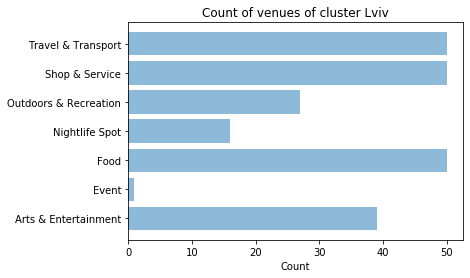

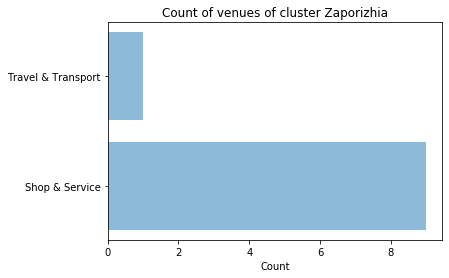

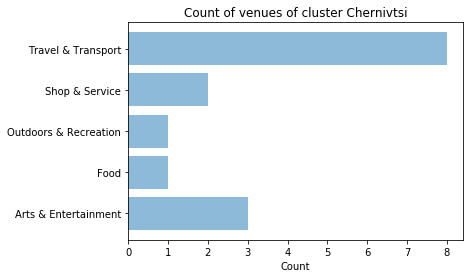

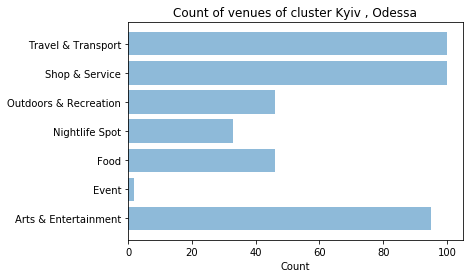

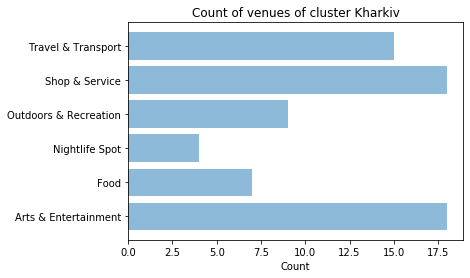

In [113]:
#plot bars for all 5 clusters with their main categories 
def plot_bar(categories, count, cities):
    y_pos = np.arange(len(categories))
    plt.barh(y_pos, count, align='center', alpha=0.5)
    plt.yticks(y_pos, categories)
    plt.xlabel('Count')
    plt.title('Count of venues of cluster ' + cities)
    plt.show()
    
for i in range(5):
    countcateg = data.loc[data['Cluster Labels'] == i].groupby('main_category').count().reset_index()
    cities = ' , '.join(data.loc[data['Cluster Labels'] == i]['city'].unique().tolist())
    plot_bar(countcateg['main_category'], countcateg['city'], cities)

Let's start from the cluster containing two cities. It's cluster 4, with Kyiv and Odesa. Most popular venues there are shops and travel services, cause there is a good transport system in these cities. Also, there are a lot of art objects. As for Kharkiv, we can see that there much less interesting for tourists venues, but most of them are arts & entertainment, so it will be interesting city for tourists. Zaporizzhia seems to have only a decade of useful for tourists spots, mostly shops. Chernivtsi is a great small town with good transport system and several art objects, but there isn't plenty of them, so it's a one-two day city for tourists. And Lviv can easily compete with Kyiv and Odesa, as there are a lot of shops, caffes and art objects that will draw tourists attention.

Now, I will explore three top cities with more details.

#### Kyiv venues categories overview

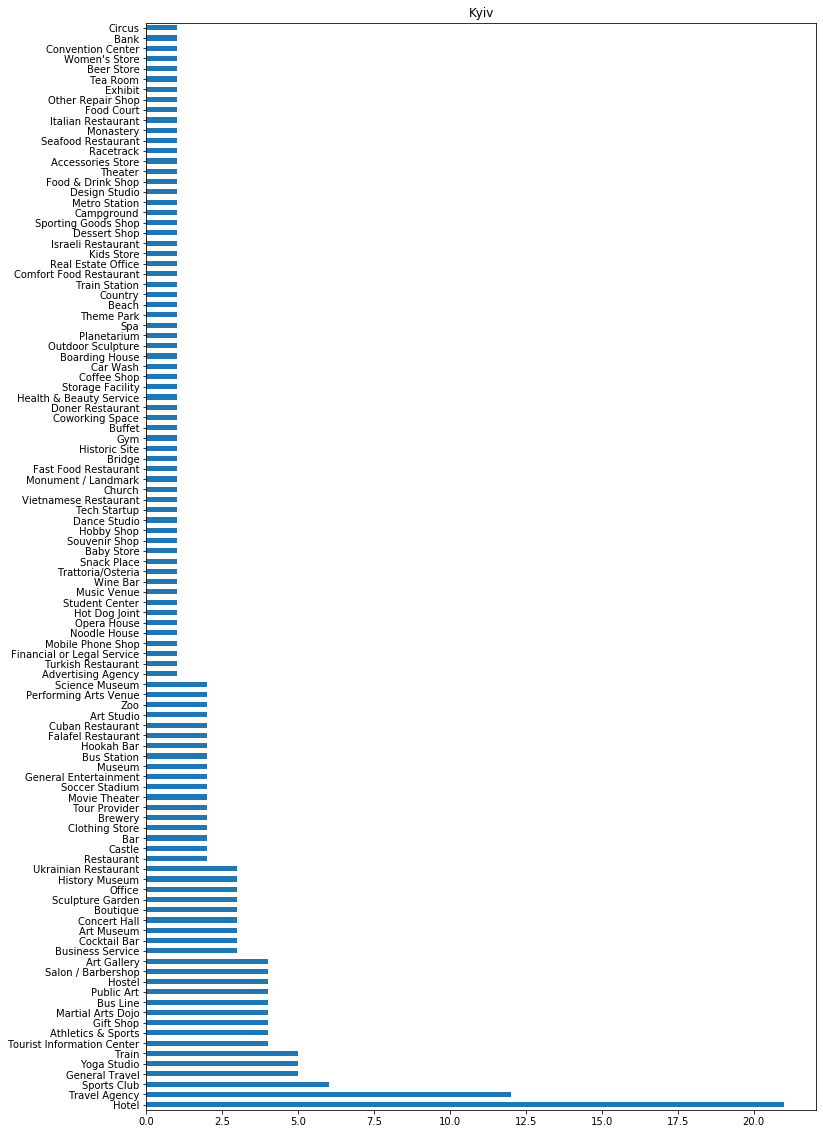

In [115]:
data.loc[data['city'] == "Kyiv"]['categories'].value_counts().plot(kind='barh', figsize=(12,20), title = "Kyiv", fontsize= 10)

Kyiv is the capital of Ukraine, the biggest and richest city. Thus there are a lot of hotels and travel agencies. There are also lot's of shops and interesting museums and landmarks. Also, this is business city, so expect to see many business centers and luxury cars.

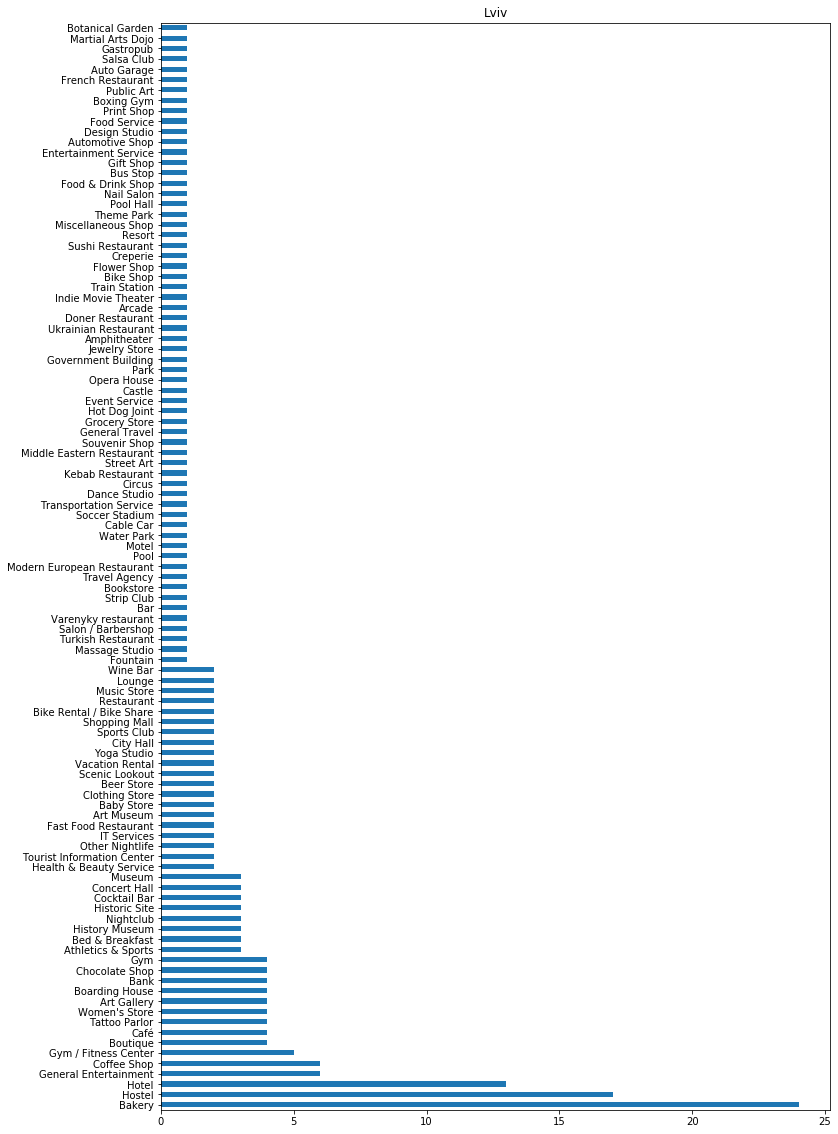

In [117]:
data.loc[data['city'] == "Lviv"]['categories'].value_counts().plot(kind='barh', figsize=(12,20), title = "Lviv", fontsize= 10)

Lviv is considered to be culture capital thanks to it's unique atmosphere and architecture. And also, this city is famous by it's bakeries and coffe. We can see that these are not just words, but facts supported by the image we see above. Apart from bakeries and coffee shops there are a lot of places where you can stay (hotels and hostels).

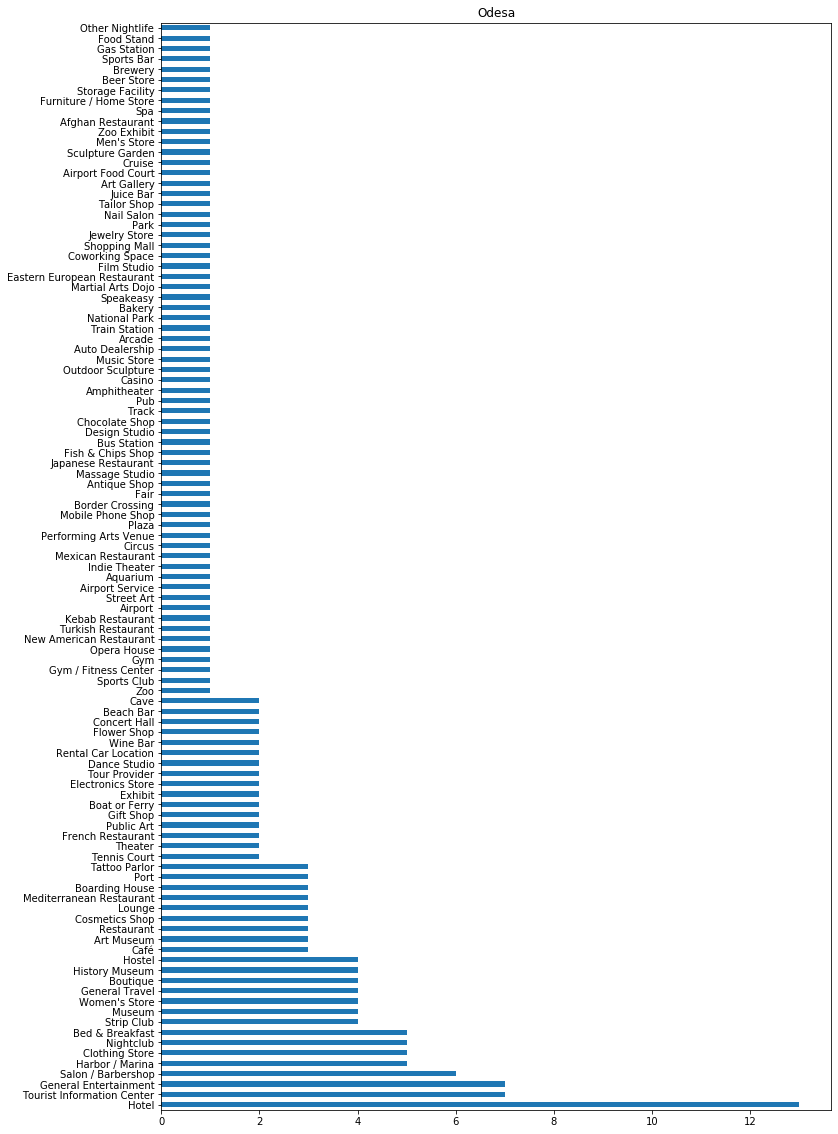

In [118]:
data.loc[data['city'] == "Odessa"]['categories'].value_counts().plot(kind='barh', figsize=(12,20), title = "Odesa", fontsize= 10)

Odesa is a beautiful city near the Black Sea. It's really populr amongst tourists thus there are a lot of hotels and places to stay. As we can see, there are a lot of night clubs and activities on it's charming quay. Apart from that, we can find some art museums and landmarks.

Let's compare these cities by some main categories for travellers.

In [122]:
# create initial dataframe with 3 cities and main foursquare categories of venues
# that may be interesting for tourists
top_cities = ['Kyiv', 'Lviv', 'Odessa']
top_categories = data['main_category'].unique().tolist()

tcdf = pd.DataFrame(columns = top_categories)

for i in range(len(top_cities)):
    tcdf = tcdf.append(pd.Series(), ignore_index=True)

tcdf = tcdf.set_index(pd.Index(top_cities))
tcdf.fillna(0, inplace = True)
tcdf

/home/serhio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


,Arts & Entertainment,Event,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Kyiv,0,0,0,0,0,0,0
Lviv,0,0,0,0,0,0,0
Odessa,0,0,0,0,0,0,0


In [123]:
# calculate venues amount for each city and category
for town in top_cities:
    city_data = data.loc[data['city'] == town].groupby('main_category').count().reset_index()[['main_category','name']]
    for i in range (city_data.shape[0]):
        tcdf.at[town , city_data['main_category'][i]]= city_data['name'][i]

tcdf

,Arts & Entertainment,Event,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Kyiv,50,1,27,10,29,50,50
Lviv,39,1,50,16,27,50,50
Odessa,45,1,19,23,17,50,50


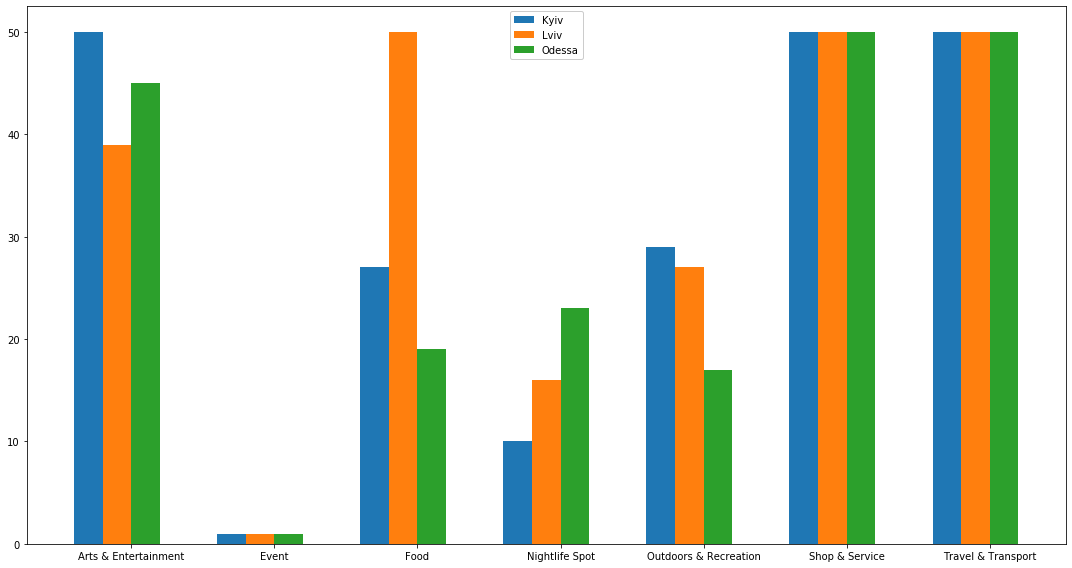

In [124]:
# visualizing received data frame
listOfcount = np.array(tcdf.values.T.tolist())
x = np.arange(listOfcount.shape[0])
dx = (np.arange(listOfcount.shape[1])-listOfcount.shape[1]/2.)/(listOfcount.shape[1]+2.)
d = 1./(listOfcount.shape[1]+2.)


fig, ax=plt.subplots(figsize=(15,8))
for i in range(listOfcount.shape[1]):
    ax.bar(x+dx[i],listOfcount[:,i], width=d, label=top_cities[i])

plt.xticks(x, top_categories)
fig.tight_layout()    
plt.legend(framealpha=4)
plt.show()

The results are pretty interesting. There is equal amount of shops in these cities and transport system is good in all of them. Kyiv is the leader at arts and entertainment as there are a lot of interesting objects and services that offer some entertainment or outdors activities. Odesa has a plenty of entertainment activities and the most developed nightlife - event top DJs sometimes give performances in Odesa's clubs. And Lviv majorly wins in Food category, thanks to it's chocolate and coffe shops, bakeries and west ukrainian cuisine.

Now, I would like to focus on nearby spots like castles, caves, national parks and palaces

In [138]:
# venues near town in radius of 50km
radius = 50000
LIMIT = 50

nearbyt_spots_categories = {'Castle': '50aaa49e4b90af0d42d5de11',
                            'Cave': '56aa371be4b08b9a8d573511',
                            'National Park': '52e81612bcbc57f1066b7a21',
                            'Palace': '52e81612bcbc57f1066b7a14'}

def get_nearby_data(search_query):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(search_query)
    print(search_query)
    latitude = location.latitude
    longitude = location.longitude
    
    frames = []
    for name, category in nearbyt_spots_categories.items():
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,category)
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # tranform venues into a dataframe
        if(venues!=[]):
            df = json_normalize(venues)
            # add column with main category of vanue
            df['location.main_category'] = name
            #append dataframe of town to list
            frames.append(df)
            
    #concat all frames of venues into one table    
    dataframe = pd.concat(frames, sort=False)
    return dataframe, latitude, longitude

def feature_selection(dataframe, city):
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    # drop unnessecary columns
    dataframe_filtered = dataframe_filtered.drop(["postalCode", "cc", "crossStreet", "state", "country", "labeledLatLngs", "distance", "address"], axis=1, errors='ignore')
    # drop city category from list 
    dataframe_filtered = dataframe_filtered[dataframe_filtered.categories != 'City']
    # delete None value from categories column
    dataframe_filtered.dropna(subset=['categories'])

    return dataframe_filtered

#list of filtered tables
tables = []
#list of coordinates of cities
coords = []
def get_cities_nearby_venues():
    for city in top_cities:
        dataframe, lat, lng = get_nearby_data(city)
        dataframe_filtered =  feature_selection(dataframe, city)
        print(dataframe_filtered.shape)
        tables.append(dataframe_filtered)
        coords.append((lat, lng))
    data = pd.concat(tables, sort=False)
    return data

nearby_data = get_cities_nearby_venues()

Kyiv


/home/serhio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


(2, 8)
Lviv
(2, 9)
Odessa
(2, 7)


In [139]:
nearby_data.shape

(6, 9)

In [140]:
nearby_data

,name,categories,lat,lng,city,formattedAddress,main_category,id,neighborhood
0,Київська Фортеця / The Kyiv Fortress (Київська...,Castle,50.433648,30.527797,Київ,"[вул. Госпітальна, 16, Київ, Україна]",Castle,4c5d584d857ca593ed81cccb,NaN
0,Київщина / Kyiv Region,National Park,50.102844,30.770859,NaN,"[Ukraine, Kyivs'ka Oblast, Україна]",National Park,572c9772498e5172ef27394b,NaN
0,Львівська Цитадель / Lviv Citadel (Львівська Ц...,Historic Site,49.832294,24.023430,Львів,"[Грабовського, Львів, Україна]",Castle,4ed646366d86a8d1a27cb44b,Галицький район
1,Lviv High Castle,Castle,49.848112,24.039094,NaN,[Україна],Castle,5cf260fbc4df1d002ca1e103,NaN
0,Odessa Catacombs,Cave,46.484240,30.735712,NaN,[Україна],Cave,5aba66713fcee8078d4f6214,NaN
0,Odessa IBB Parkı,National Park,46.490110,30.740070,NaN,[Україна],National Park,571ca3f2498e92ae0450d7e8,NaN


In [141]:
nearby_data = nearby_data.drop(["city", "lat", "lng", "neighborhood", "id"], axis=1, errors='ignore')
nearby_data

,name,categories,formattedAddress,main_category
0,Київська Фортеця / The Kyiv Fortress (Київська...,Castle,"[вул. Госпітальна, 16, Київ, Україна]",Castle
0,Київщина / Kyiv Region,National Park,"[Ukraine, Kyivs'ka Oblast, Україна]",National Park
0,Львівська Цитадель / Lviv Citadel (Львівська Ц...,Historic Site,"[Грабовського, Львів, Україна]",Castle
1,Lviv High Castle,Castle,[Україна],Castle
0,Odessa Catacombs,Cave,[Україна],Cave
0,Odessa IBB Parkı,National Park,[Україна],National Park


As we can see from the data frame, there are:
 - two castles near Lviv
 - one castle and one national park near Kyiv
 - one cave and one national park near Odesa

### Results and Discussion <a name="results"></a>

My analysis shows, that Ukiane has some really interesting cities to visit and a lot of interesting places to see and things to do. This analysis shows thath there are big cities with lots of activities and some other cities that might be not so popular amongst tourists. Our top 3 cities: Lviv, Odesa and Kyiv can be interesting for different people from different age groups. All of them have good transport system, a hige variety of places where to stay and most important - beautiful landmarks.

Here is my pieces of advice about this cities:
If you're looking for nice and charming atmosphere with smell of sweets, than Lviv is your bet.
If ypu're fan of activities and big cities - go to Kyiv and you will be satisfied.
If you're in mood for parties, sea and rest - visit Odesa and get there everything you desire.

Visit Ukraine and you'll get unforgettable emotions and impression!

### Conclusion <a name="conclusion"></a>

I wanted to show to trvel agencies that it is possible to discover country and it's most beautiful cities for tourism withut spending weeks discovering the city and a huge amount of money on that. It can be done with the help of Data Science in a smart way. And I believe, that the results are pretty good and trustworthy. Also, this research will be useful for people that want to discover some new country and want to select appropriate city for their wishes.